In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
## Display all the columns of the dataframe
pd.pandas.set_option('display.max_columns',None)

from scipy import stats
from scipy.stats import norm, skew # for some statistics
import warnings # to ignore warning
from sklearn.preprocessing import RobustScaler, PowerTransformer, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

import lazypredict
from lazypredict.Supervised import LazyRegressor
import optuna
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LassoCV, RidgeCV

from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
import joblib

print("Library Imported!!")

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\hp\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Library Imported!!


In [2]:
# load train and test dataset
train_df = pd.read_csv("train1.csv")
test_df = pd.read_csv("test1.csv")

# combined train and test datasets
combined_df = pd.concat([train_df,test_df],axis=0)

In [3]:
train_df.shape

(1460, 81)

In [4]:
train_dtype = train_df.dtypes
train_dtype.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [5]:
train_df.isnull().sum().sort_values(ascending = False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
Utilities          0
dtype: int64

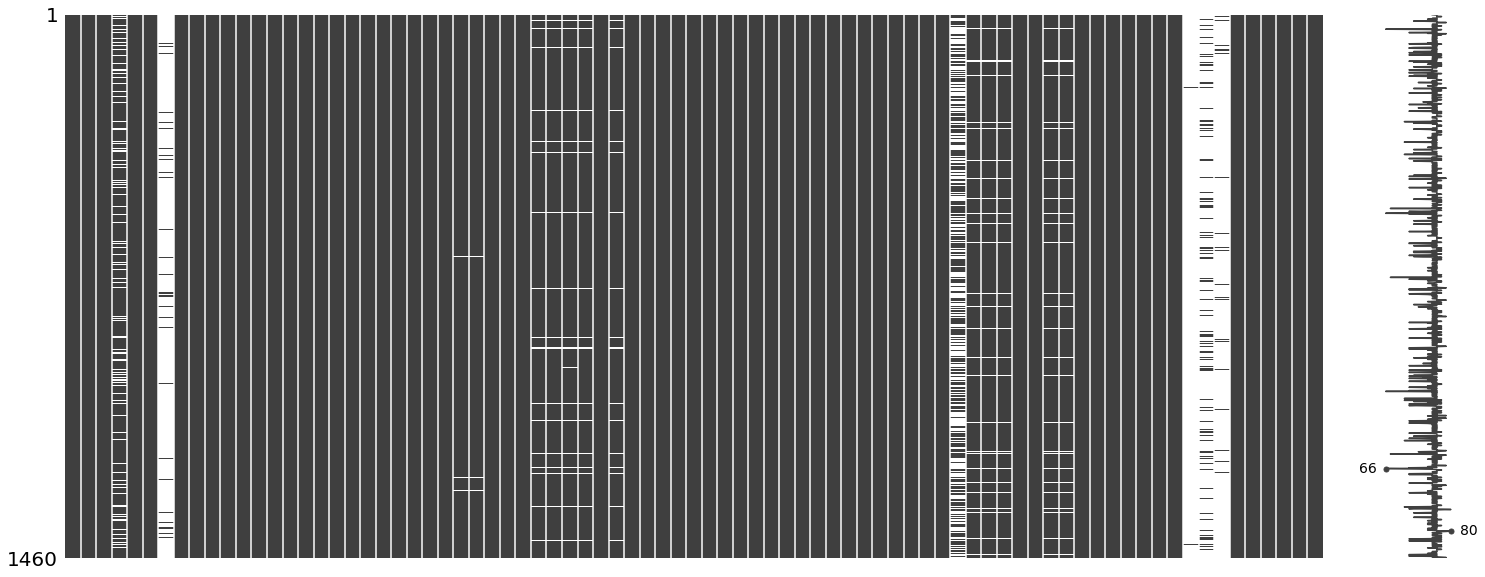

In [6]:
msno.matrix(train_df)

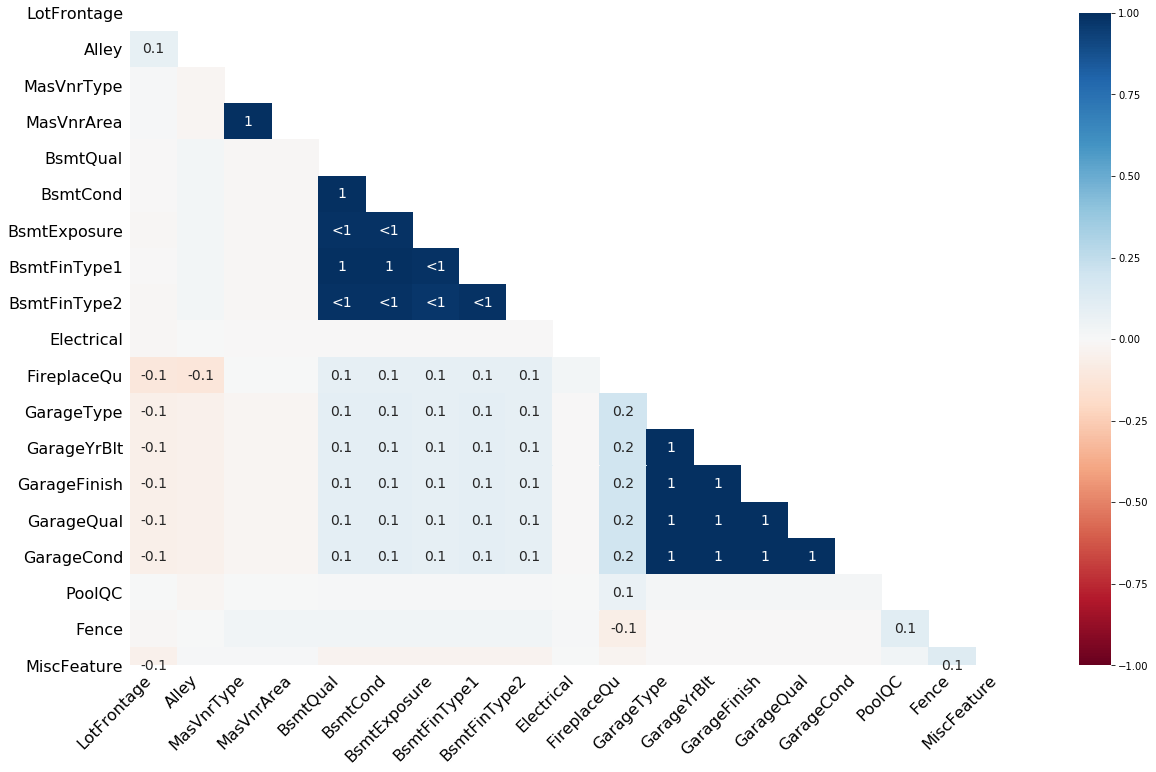

In [7]:
msno.heatmap(train_df)

# Data Type Comparison


In [8]:
test_dtype = test_df.dtypes
test_dtype.value_counts()

object     43
int64      26
float64    11
dtype: int64

In [9]:
trn_dtype = train_dtype.drop('SalePrice')
trn_dtype.compare(test_dtype)

,self,other
BsmtFinSF1,int64,float64
BsmtFinSF2,int64,float64
BsmtUnfSF,int64,float64
TotalBsmtSF,int64,float64
BsmtFullBath,int64,float64
BsmtHalfBath,int64,float64
GarageCars,int64,float64
GarageArea,int64,float64


In [10]:
null_train = train_df.isnull().sum()
null_test = test_df.isnull().sum()
null_train = null_train.drop('SalePrice')
null_comp_df = null_train.compare(null_test).sort_values(['self'],ascending = [False])
null_comp_df 

,self,other
PoolQC,1453.00,1456.00
MiscFeature,1406.00,1408.00
Alley,1369.00,1352.00
Fence,1179.00,1169.00
FireplaceQu,690.00,730.00
LotFrontage,259.00,227.00
GarageType,81.00,76.00
GarageCond,81.00,78.00
GarageYrBlt,81.00,78.00
GarageFinish,81.00,78.00


In [11]:
numerical_features = [col for col in train_df.columns if train_df[col].dtypes != 'O']
discrete_features = [col for col in numerical_features if len(train_df[col].unique()) < 25 and col not in ['Id']]
continuous_features = [feature for feature in numerical_features if feature not in discrete_features+['Id']]
categorical_features = [col for col in train_df.columns if train_df[col].dtype == 'O']

print("Total Number of Numerical Columns : ",len(numerical_features))
print("Number of discrete features : ",len(discrete_features))
print("No of continuous features are : ", len(continuous_features))
print("Number of discrete features : ",len(categorical_features))

Total Number of Numerical Columns :  38
Number of discrete features :  18
No of continuous features are :  19
Number of discrete features :  43


In [12]:
combined_df["Label"] = "test"
combined_df["Label"][:1460] = "train"

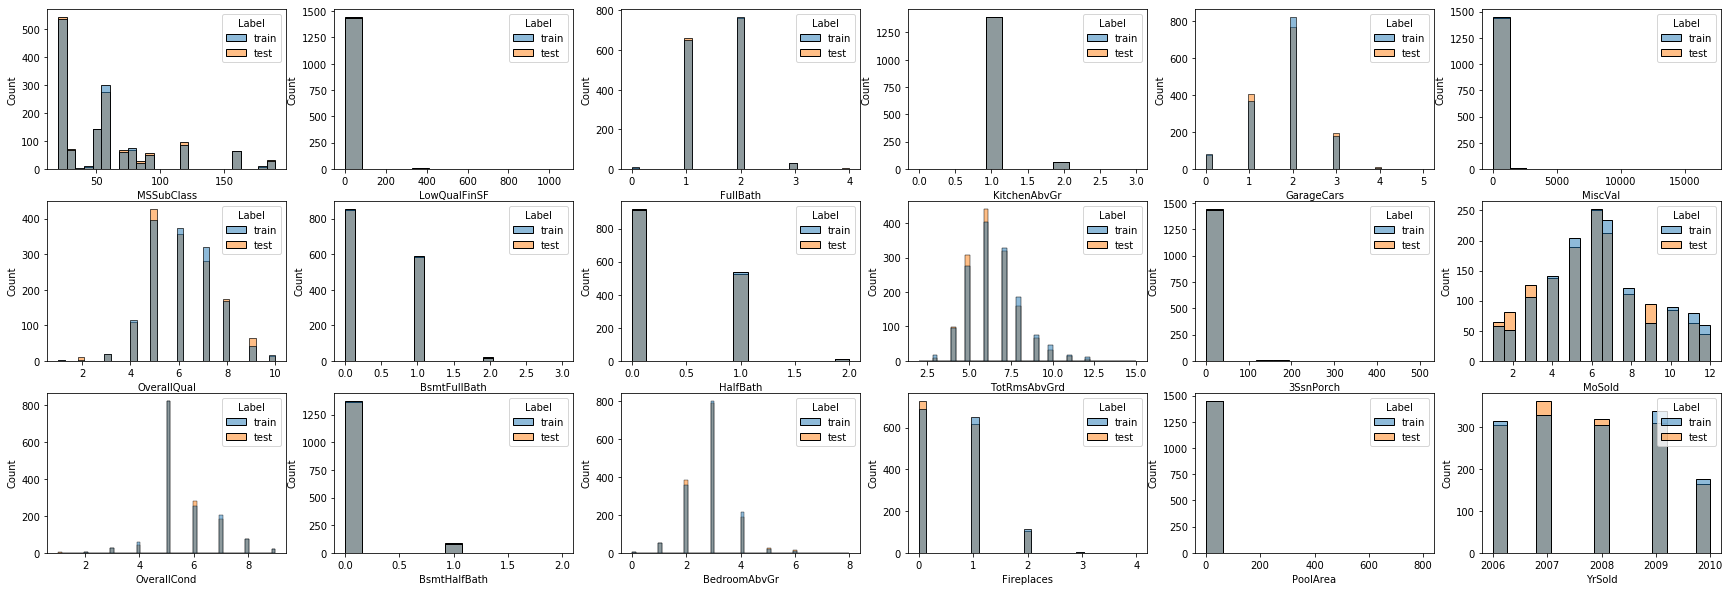

In [13]:
f, axes = plt.subplots(3,6 , figsize=(30, 10), sharex=False)
for i, feature in enumerate(discrete_features):
    sns.histplot(data=combined_df, x = feature, hue="Label",ax=axes[i%3, i//3]) 

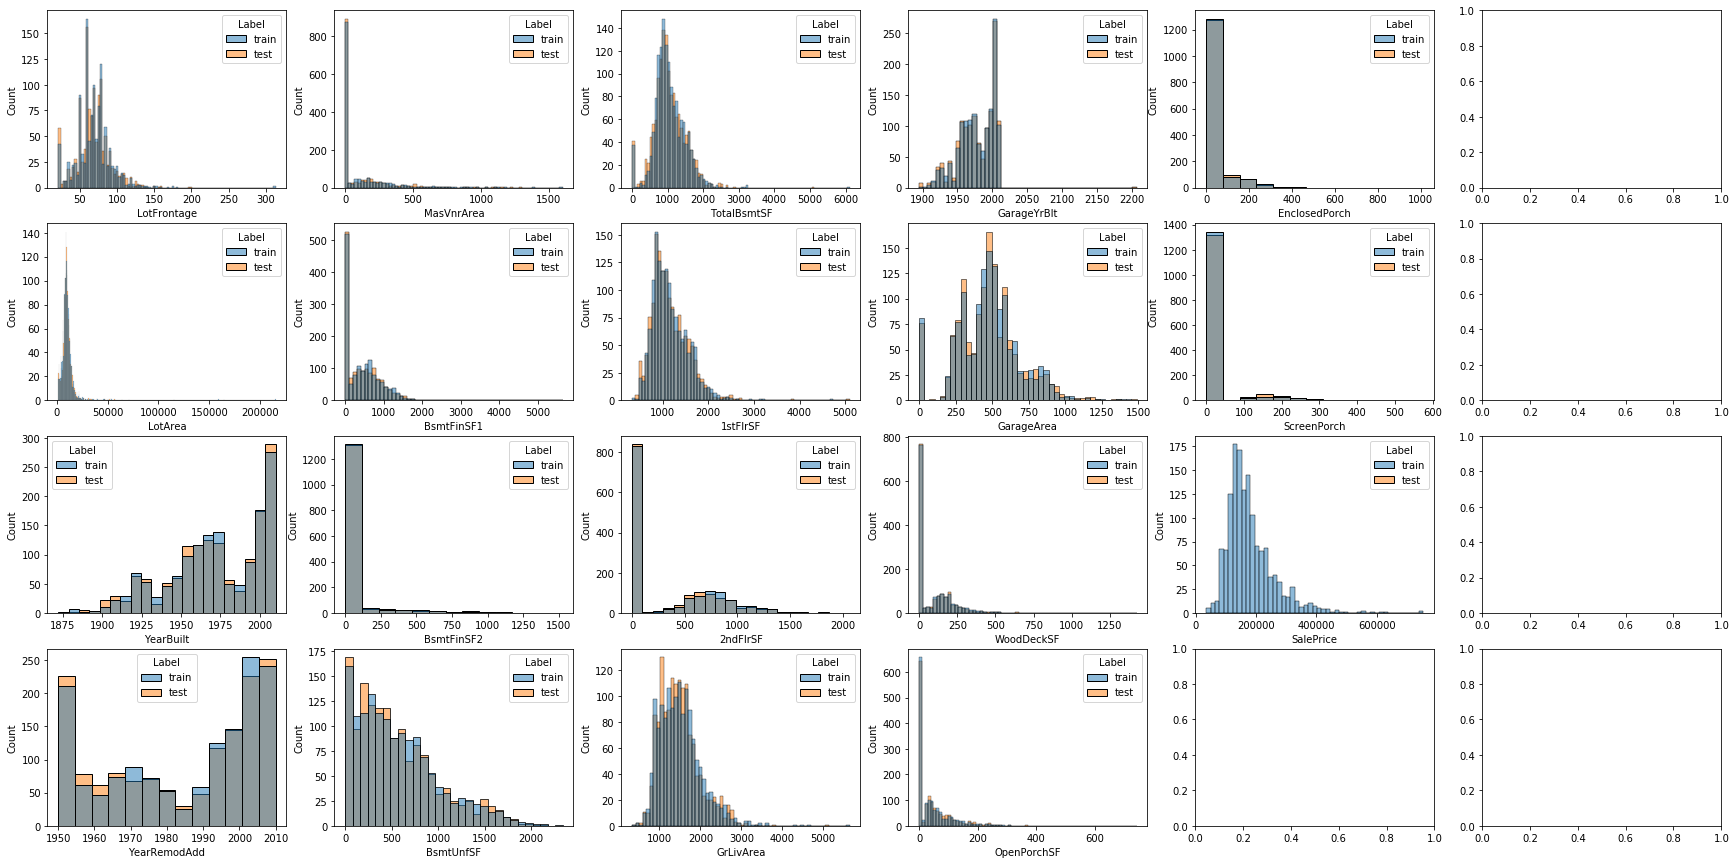

In [15]:
f, axes = plt.subplots(4,6 , figsize=(30, 15), sharex=False)
for i, feature in enumerate(continuous_features):
    sns.histplot(data=combined_df, x = feature, hue="Label",ax=axes[i%4, i//4])

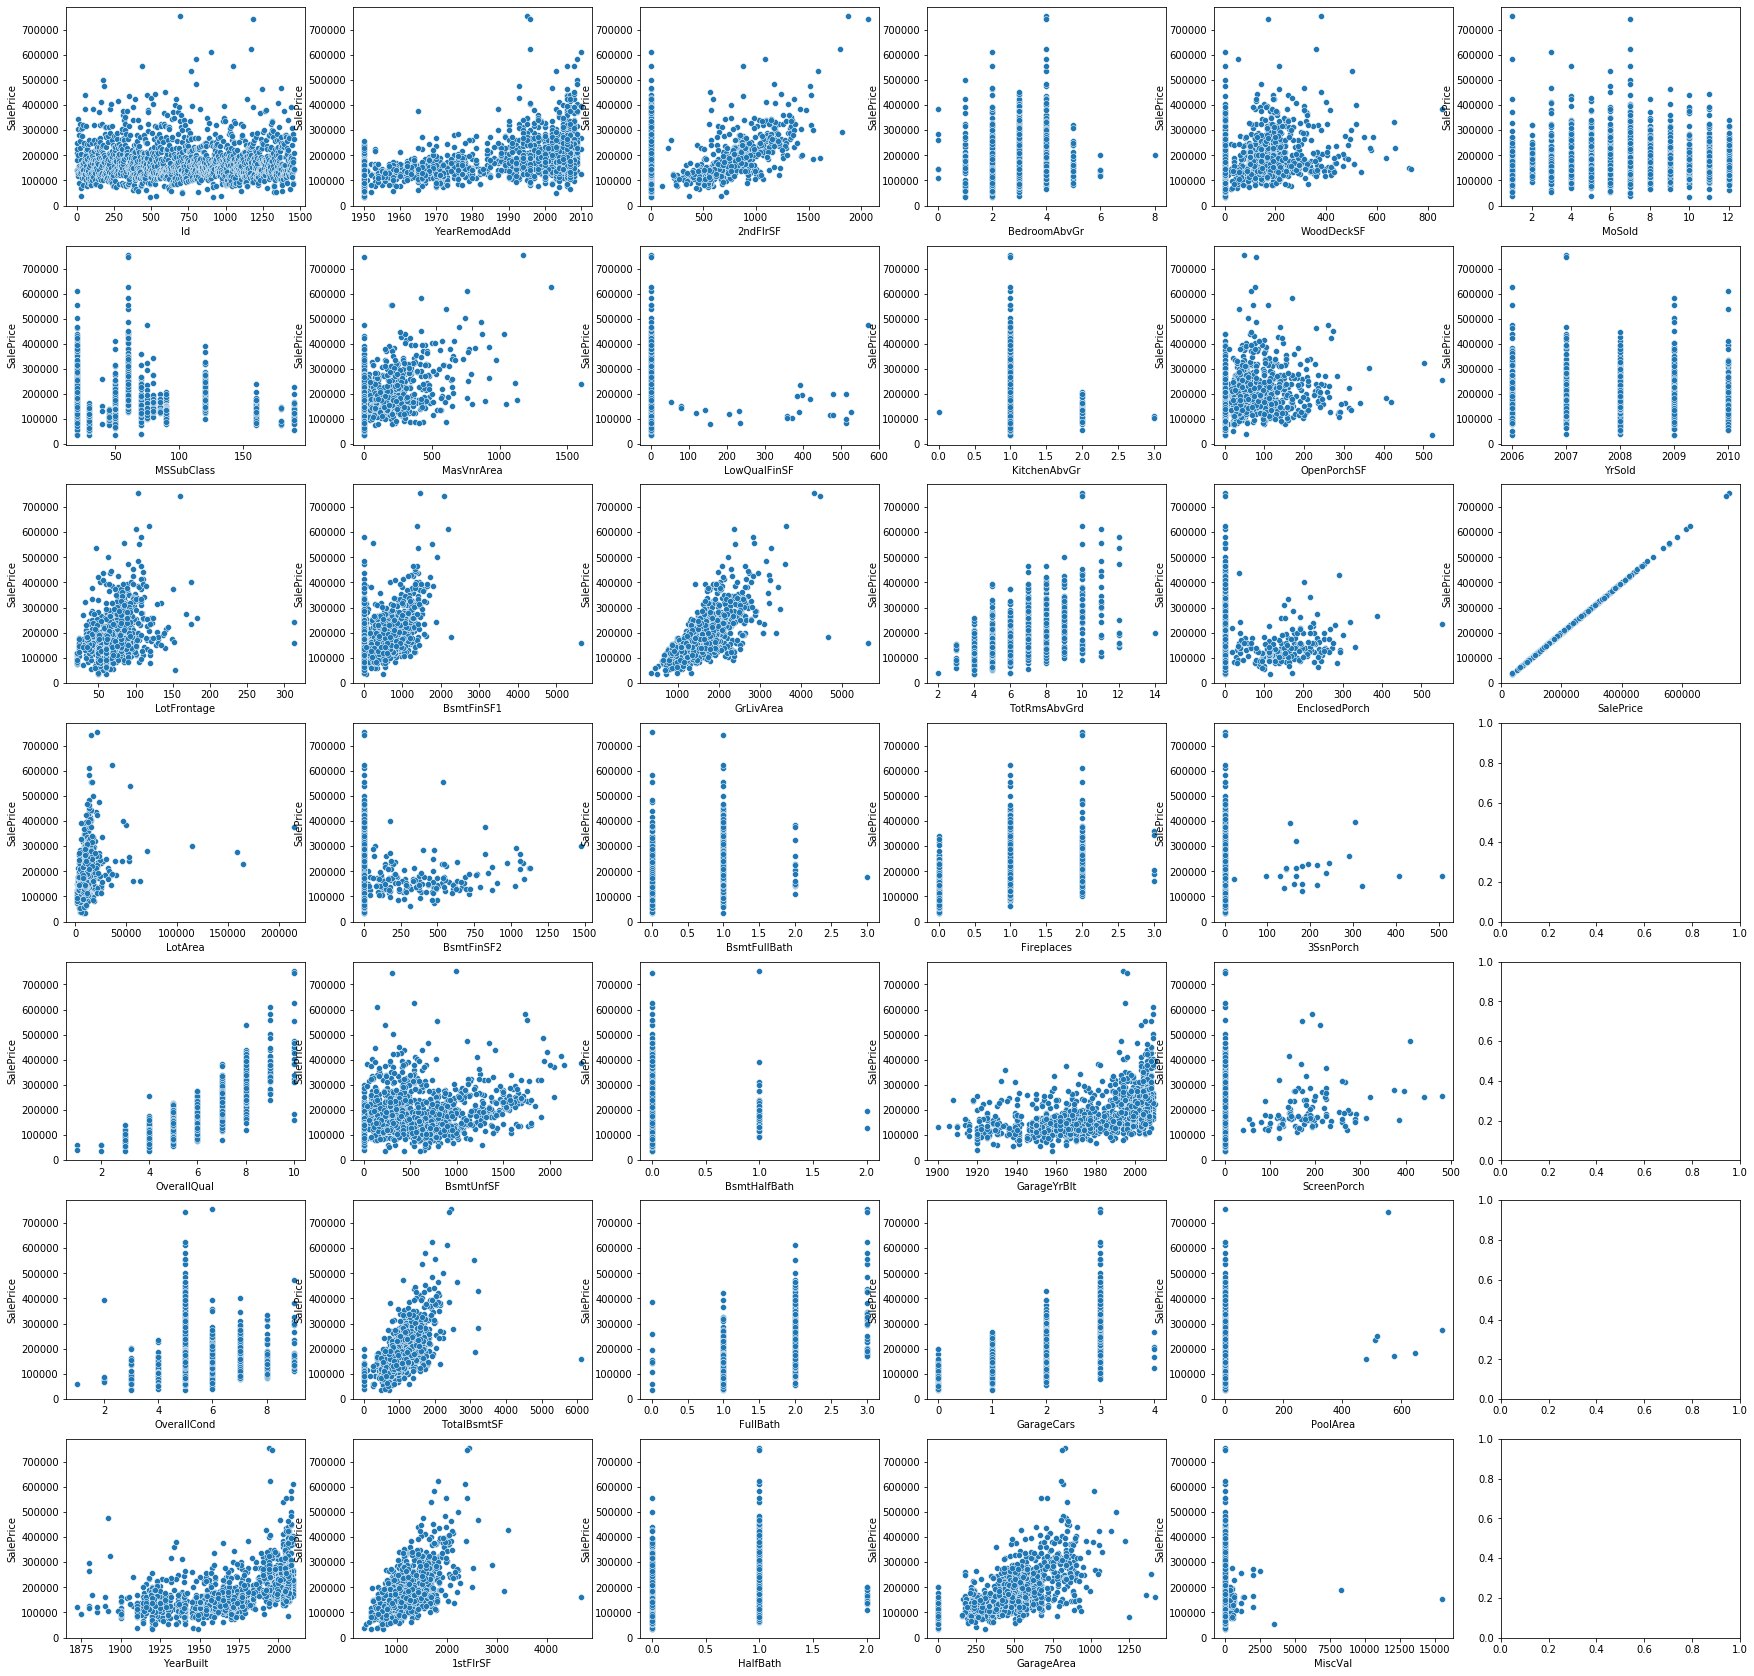

In [16]:
f, axes = plt.subplots(7,6 , figsize=(30, 30), sharex=False)
for i, feature in enumerate(numerical_features):
    sns.scatterplot(data=combined_df, x = feature, y= "SalePrice",ax=axes[i%7, i//7])

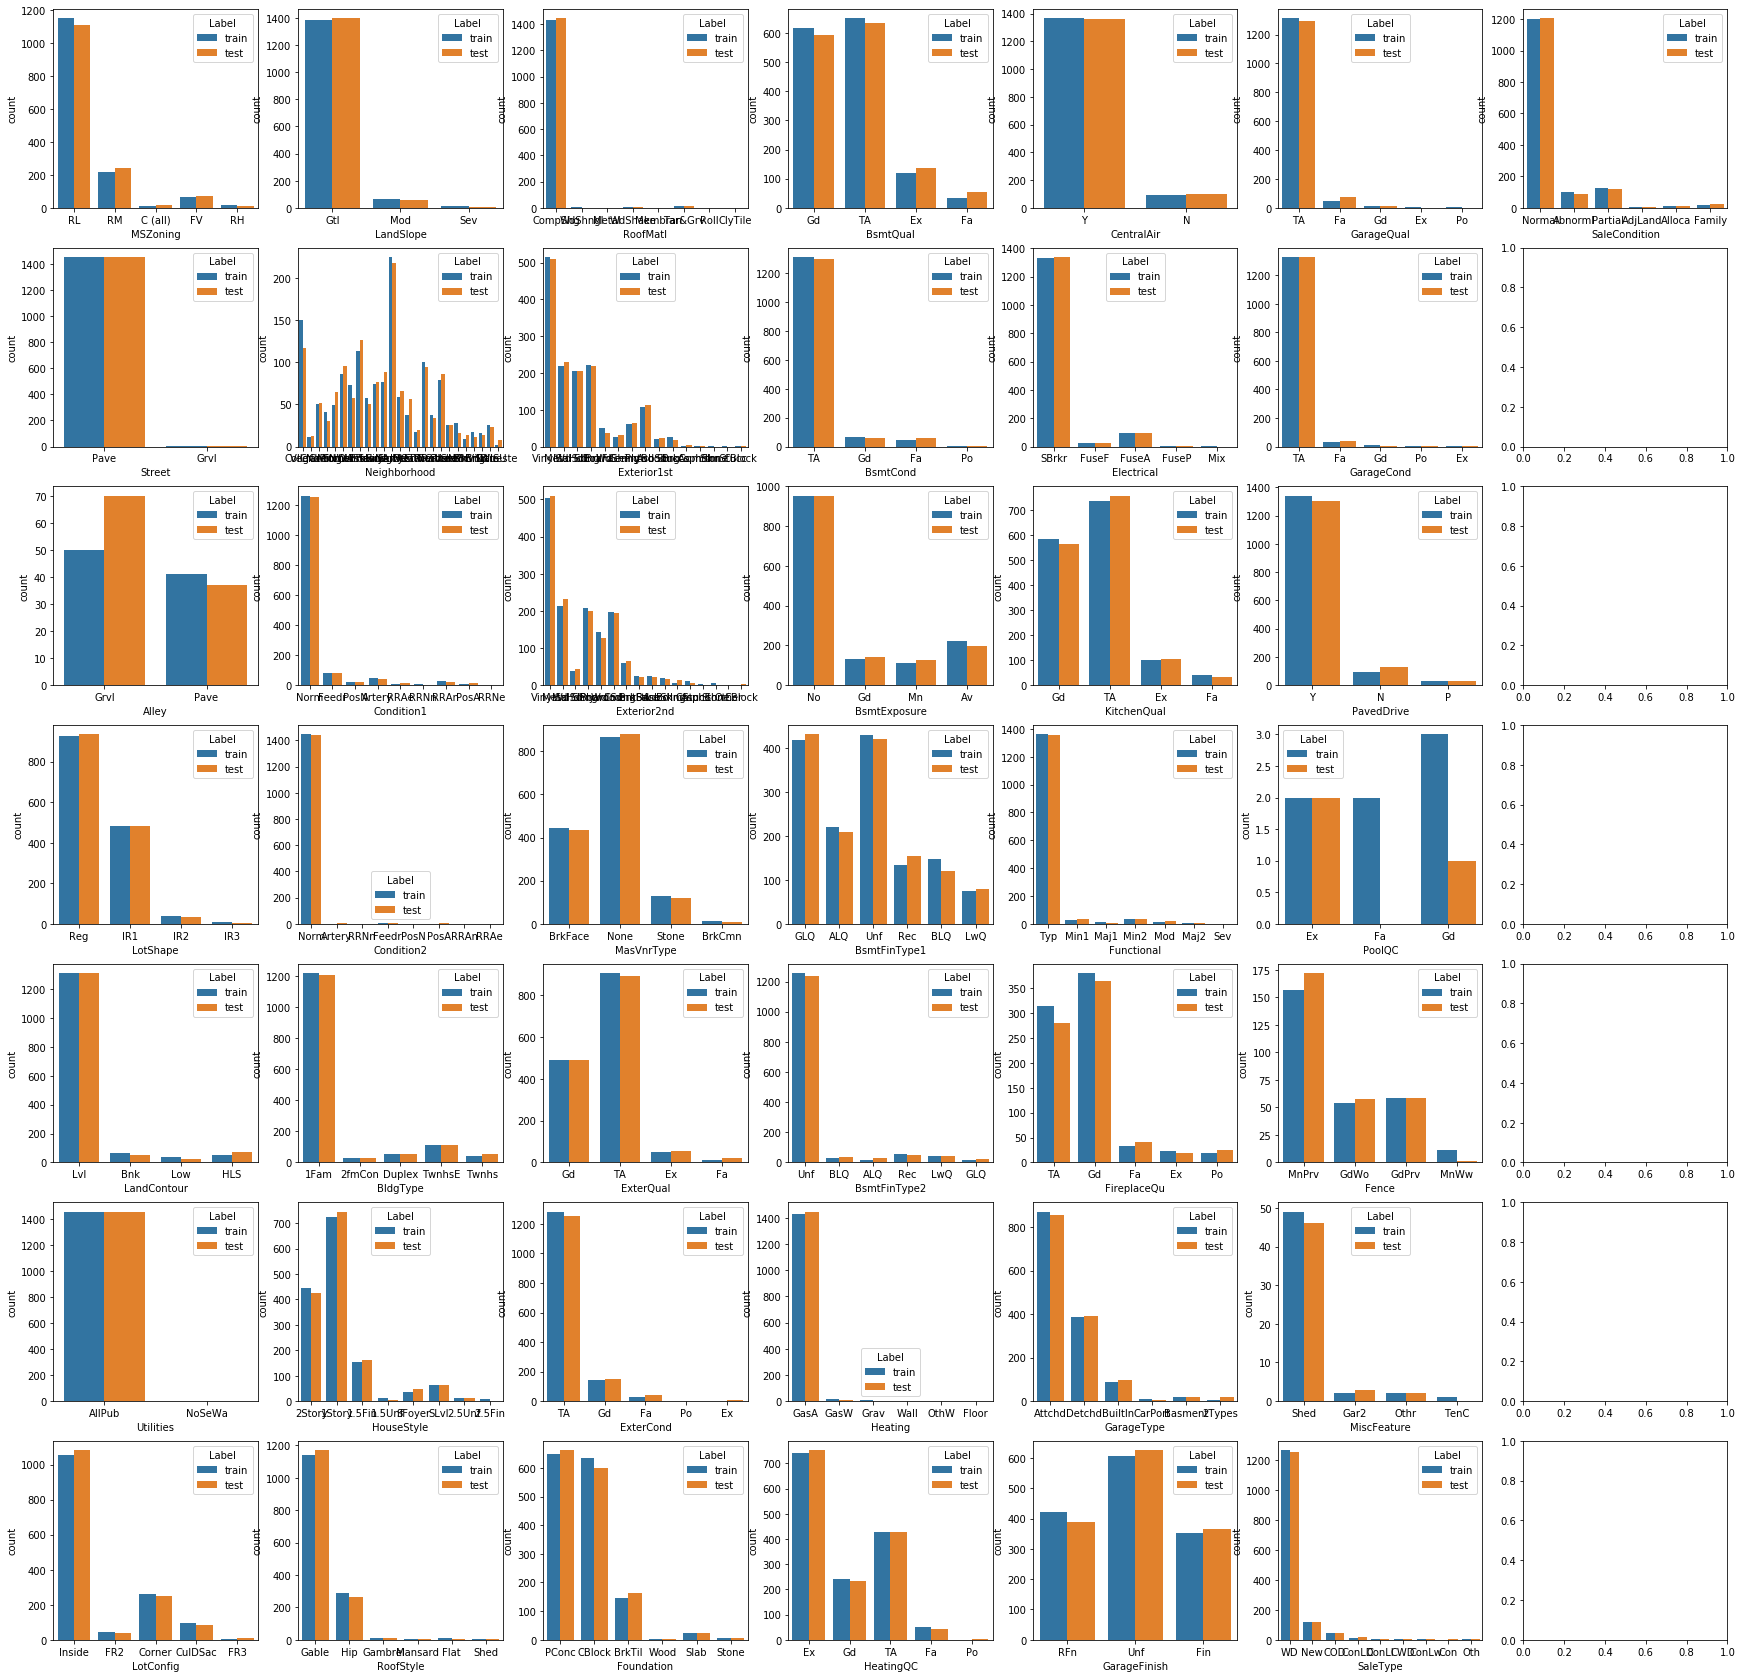

In [17]:
f, axes = plt.subplots(7,7 , figsize=(30, 30), sharex=False)
for i, feature in enumerate(categorical_features):
    sns.countplot(data = combined_df, x = feature, hue="Label",ax=axes[i%7, i//7])

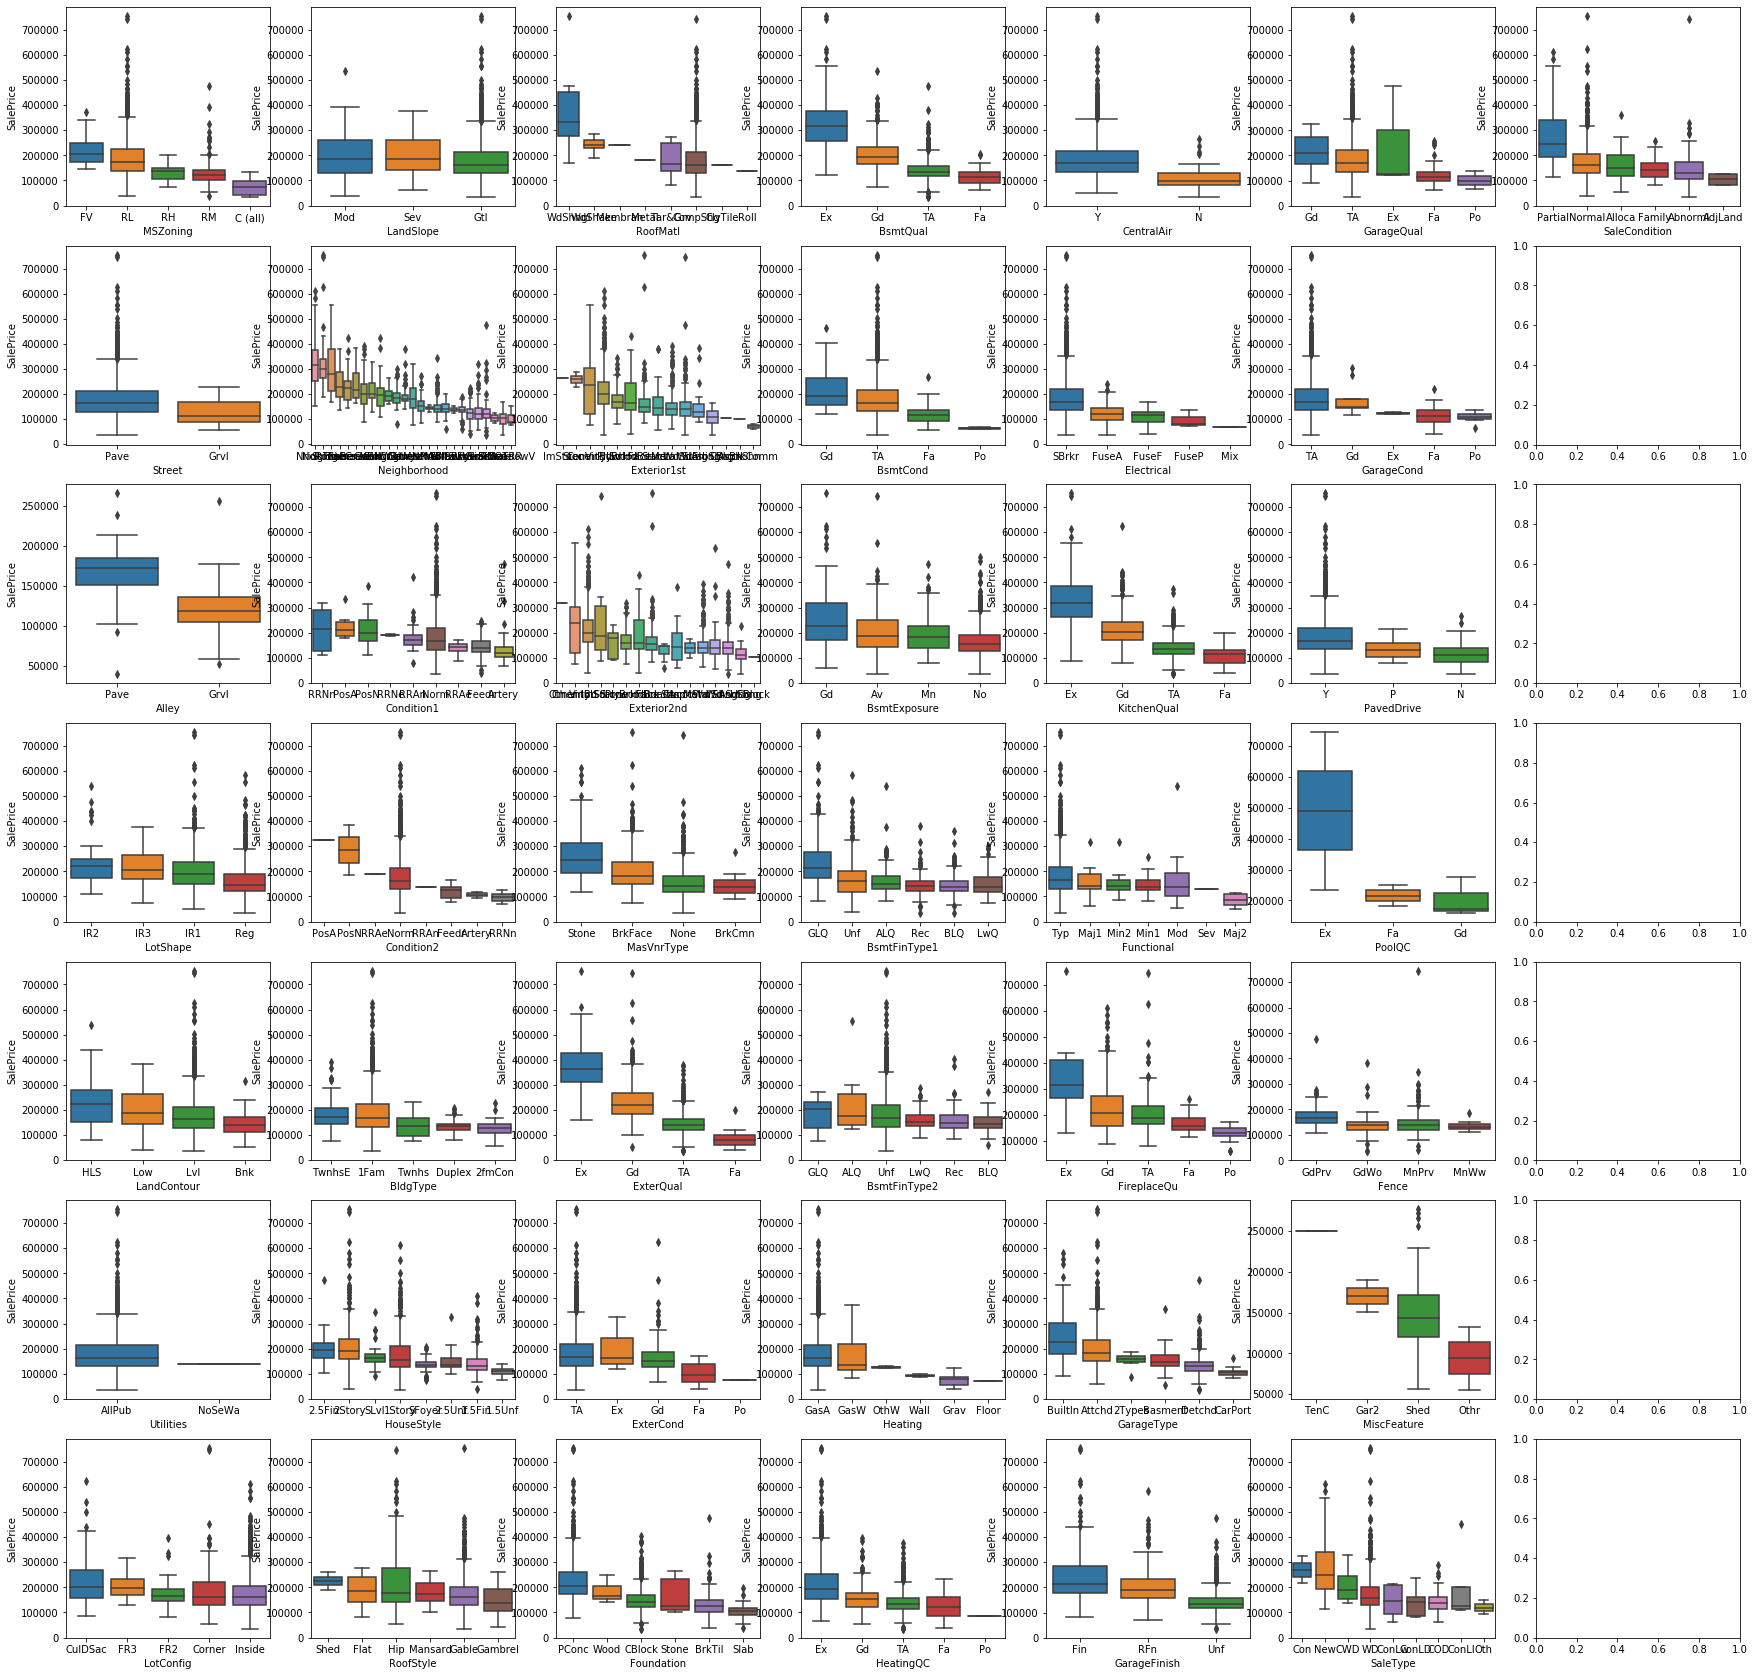

In [18]:
f, axes = plt.subplots(7,7 , figsize=(30, 30), sharex=False)
for i, feature in enumerate(categorical_features):
    sort_list = sorted(combined_df.groupby(feature)['SalePrice'].median().items(), key= lambda x:x[1], reverse = True)
    order_list = [x[0] for x in sort_list ]
    sns.boxplot(data = combined_df, x = feature, y = 'SalePrice', order=order_list, ax=axes[i%7, i//7])
plt.show()

In [19]:
year_feature = [col for col in combined_df.columns if 'Yr' in col or 'Year' in col]
year_feature

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

Text(0.5, 1.0, 'House price vs YearSold')

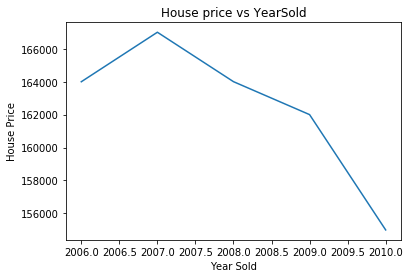

In [20]:
combined_df.groupby('YrSold')['SalePrice'].median().plot()
plt.xlabel('Year Sold')
plt.ylabel('House Price')
plt.title('House price vs YearSold')

# Data Correlation

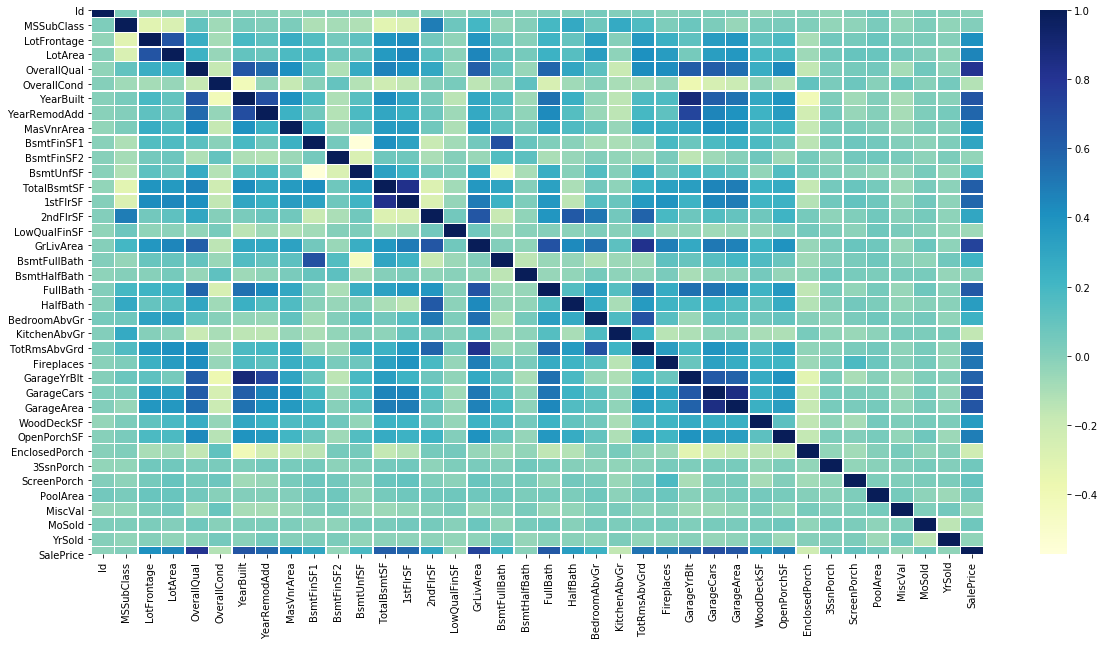

In [21]:
training_corr = train_df.corr(method='spearman')
plt.figure(figsize=(20,10))
sns.heatmap(training_corr, cmap="YlGnBu", linewidths=.5)

# Feature Engineering

In [22]:
drop_columns = ["Id", "Alley", "Fence", "LotFrontage", "FireplaceQu", "PoolArea", "LowQualFinSF", "3SsnPorch", "MiscVal", 'RoofMatl','Street','Condition2','Utilities','Heating','Label']
#  Drop columns
print("Number of columns before dropping : ",len(combined_df.columns))
print("Number of dropping columns : ",len(drop_columns))
combined_df.drop(columns=drop_columns, inplace=True, errors='ignore')
print("Number of columns after dropping : ",len(combined_df.columns))

Number of columns before dropping :  82
Number of dropping columns :  15
Number of columns after dropping :  67


In [23]:
for feature in ['YearBuilt','YearRemodAdd','GarageYrBlt']:

    combined_df[feature]=combined_df['YrSold']-combined_df[feature]

combined_df[['YearBuilt','YearRemodAdd','GarageYrBlt']].head()

,YearBuilt,YearRemodAdd,GarageYrBlt
0,5,5,5.00
1,31,31,31.00
2,7,6,7.00
3,91,36,8.00
4,8,8,8.00


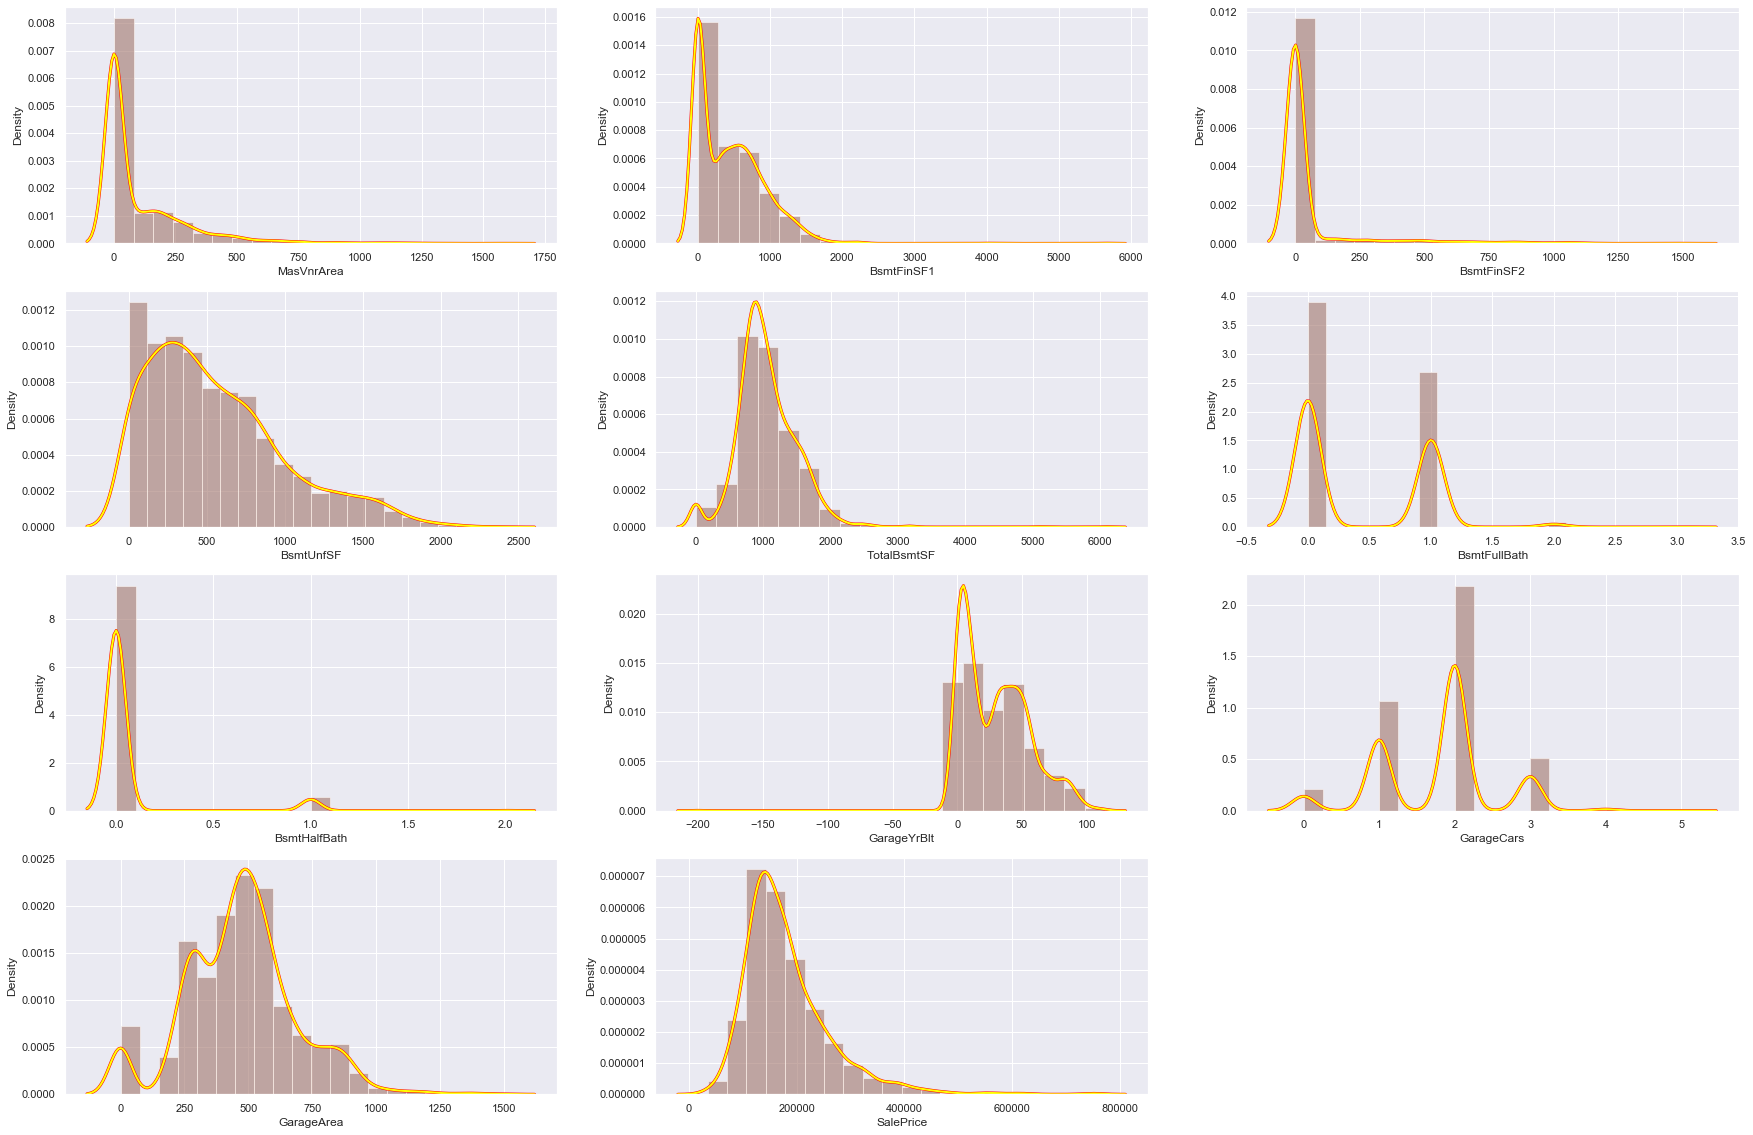

In [26]:
# check the normal distribution of columns having null values by filling with the mean value
null_features_numerical = [col for col in combined_df.columns if combined_df[col].isnull().sum() > 0 and col not in categorical_features]
plt.figure(figsize=(30,20))
sns.set()

warnings.simplefilter("ignore")
for i,var in enumerate(null_features_numerical):
  plt.subplot(4,3,i+1)
  sns.distplot(combined_df[var],bins=20,kde_kws={'linewidth':3,'color':'red'},label="original")
  sns.distplot(combined_df[var],bins=20,kde_kws={'linewidth':2,'color':'yellow'},label="mean")

In [27]:
for col in null_features_numerical:
    if col not in drop_columns:    
        # combined_df[col] = combined_df[col].fillna(combined_df[col].mean())
        combined_df[col] = combined_df[col].fillna(0.0)

# Fill Missing Values - Categorical Feature

In [28]:
null_features_categorical = [col for col in combined_df.columns if combined_df[col].isnull().sum() > 0 and col in categorical_features]
cat_feature_mode = ["SaleType", "Exterior1st", "Exterior2nd", "KitchenQual", "Electrical", "Functional"]

for col in null_features_categorical:
  if col != 'MSZoning' and col not in cat_feature_mode:
    combined_df[col] = combined_df[col].fillna('NA')
  else:
    combined_df[col] = combined_df[col].fillna(combined_df[col].mode()[0])

# Convert Numerical feature to Categorical

In [29]:
# Convert "numerical" feature to categorical
convert_list = ['MSSubClass']
for col in convert_list:
  combined_df[col] = combined_df[col].astype('str')

# Apply PowerTransformer to columns

In [30]:
numeric_feats = combined_df.dtypes[combined_df.dtypes != 'object'].index
# get the features except object types

# check the skew of all numerical features
skewed_feats = combined_df[numeric_feats].apply(lambda x : skew(x.dropna())).sort_values(ascending = False)
print('\n Skew in numberical features: \n')
skewness_df = pd.DataFrame({'Skew' : skewed_feats})
print(skewness_df.head(10))


 Skew in numberical features: 

               Skew
LotArea       12.82
KitchenAbvGr   4.30
BsmtFinSF2     4.15
EnclosedPorch  4.00
ScreenPorch    3.95
BsmtHalfBath   3.93
MasVnrArea     2.61
OpenPorchSF    2.54
WoodDeckSF     1.84
1stFlrSF       1.47


In [ ]:
# Apply PowerTransformer to columns
log_list = ['BsmtUnfSF', 'LotArea', '1stFlrSF', 'GrLivArea', 'TotalBsmtSF', 'GarageArea']
# log_list = ['LotArea', 'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch', 'BsmtHalfBath', 'MasVnrArea', 'OpenPorchSF']
# log_list = skewness_df[abs(skewness_df) > 1].dropna().index


for col in log_list:
    power = PowerTransformer(method='yeo-johnson', standardize=True)
    combined_df[[col]] = power.fit_transform(combined_df[[col]]) # fit with combined_data to avoid overfitting with training data?

print('Number of skewed numerical features got transform : ', len(log_list))

In [40]:

regroup_dict = {
    'HeatingQC':['Fa','Po'],
    'GarageQual':['Fa','Po'],
    'GarageCond':['Fa','Po'],}
 

for col, regroup_value in regroup_dict.items():
    mask = combined_df[col].isin(regroup_value)
    combined_df[col][mask] = 'Other'

# Get-Dummies


In [41]:
combined_df = pd.get_dummies(combined_df).reset_index(drop=True)

In [42]:
new_train_data = combined_df.iloc[:len(train_df), :]
new_test_data = combined_df.iloc[len(train_df):, :]
X_train = new_train_data.drop('SalePrice', axis=1)
y_train = np.log1p(new_train_data['SalePrice'].values.ravel())
X_test = new_test_data.drop('SalePrice', axis=1)

In [44]:
pre_precessing_pipeline = make_pipeline(RobustScaler(), 
                                        # VarianceThreshold(0.001),
                                       )

X_train = pre_precessing_pipeline.fit_transform(X_train)
X_test = pre_precessing_pipeline.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(1460, 270)
(1459, 270)


# Model Development

In [45]:
x_train1,x_test1,y_train1,y_test1=train_test_split(X_train,y_train,test_size=0.25)

reg= LazyRegressor(verbose=0,ignore_warnings=True,custom_metric=None)
train,test=reg.fit(x_train1,x_test1,y_train1,y_test1)
test

100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:48<00:00,  1.12s/it]


,R-Squared,RMSE,Time Taken
Model,,,
GradientBoostingRegressor,0.91,0.12,1.23
LGBMRegressor,0.90,0.13,0.88
HistGradientBoostingRegressor,0.90,0.13,11.42
XGBRegressor,0.89,0.14,2.14
ExtraTreesRegressor,0.89,0.14,4.10
RandomForestRegressor,0.88,0.15,3.17
GammaRegressor,0.88,0.15,0.18
GeneralizedLinearRegressor,0.87,0.15,0.08
TweedieRegressor,0.87,0.15,0.09


In [46]:
RANDOM_SEED = 23

# 10-fold CV
kfolds = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

In [47]:
def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score} \nOptimized parameters: {params}")

# Ridge Regression

In [48]:
def ridge_objective(trial):

    _alpha = trial.suggest_float("alpha", 0.1, 20)

    ridge = Ridge(alpha=_alpha, random_state=RANDOM_SEED)

    score = cross_val_score(
        ridge,X_train,y_train, cv=kfolds, scoring="neg_root_mean_squared_error"
    ).mean()
    return score



# Best score: -0.13586760243668033 
ridge_params = {'alpha': 19.997759851201025}

In [49]:
ridge = Ridge(**ridge_params, random_state=RANDOM_SEED)
ridge.fit(X_train,y_train)

Ridge(alpha=19.997759851201025, random_state=23)

# Lasso Regression

In [50]:
def lasso_objective(trial):

    _alpha = trial.suggest_float("alpha", 0.0001, 1)

    lasso = Lasso(alpha=_alpha, random_state=RANDOM_SEED)

    score = cross_val_score(
        lasso,X_train,y_train, cv=kfolds, scoring="neg_root_mean_squared_error"
    ).mean()
    return score




# Best score: -0.13319435700230317 
lasso_params = {'alpha': 0.0006224224345371836}

In [51]:
lasso = Lasso(**lasso_params, random_state=RANDOM_SEED)
lasso.fit(X_train,y_train)

Lasso(alpha=0.0006224224345371836, random_state=23)

# Gradient Boosting Regresso

In [52]:
def gbr_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 2000)
    _learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    _max_depth = trial.suggest_int("max_depth", 1, 20)
    _min_samp_split = trial.suggest_int("min_samples_split", 2, 20)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 20)
    _max_features = trial.suggest_int("max_features", 10, 50)

    gbr = GradientBoostingRegressor(
        n_estimators=_n_estimators,
        learning_rate=_learning_rate,
        max_depth=_max_depth, 
        max_features=_max_features,
        min_samples_leaf=_min_samples_leaf,
        min_samples_split=_min_samp_split,
        
        random_state=RANDOM_SEED,
    )

    score = cross_val_score(
        gbr, X_train,y_train, cv=kfolds, scoring="neg_root_mean_squared_error"
    ).mean()
    return score





# Best score: -0.12736574760627803 
gbr_params = {'n_estimators': 1831, 'learning_rate': 0.01325036780847096, 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 29}


In [53]:
gbr = GradientBoostingRegressor(random_state=RANDOM_SEED, **gbr_params)
gbr.fit(X_train,y_train)

GradientBoostingRegressor(learning_rate=0.01325036780847096, max_features=29,
                          min_samples_leaf=2, min_samples_split=17,
                          n_estimators=1831, random_state=23)